In [59]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!pip install pyriemann

In [61]:
import numpy as np
import pandas as pd

import os
# Get the path to your Google Drive
drive_path = "/content/drive/My Drive"

# Combine the path to your Google Drive with the path to your data
local_path = os.path.join(drive_path, "EEG_Seizure_Analysis/Data/")

# Set the local path
os.chdir('.')

# Get the data
npz_file = np.load(f'{local_path}eeg-seizure_train.npz', allow_pickle=True)
signals_train = npz_file['train_signals']
labels_train = npz_file['train_labels']

npz_file = np.load(f'{local_path}eeg-seizure_val.npz', allow_pickle=True)
signals_val = npz_file['val_signals']
labels_val = npz_file['val_labels']

npz_file = np.load(f'{local_path}eeg-seizure_test.npz', allow_pickle=True)
signals_test = npz_file['test_signals']


print('Train data shape is {}'.format(signals_train.shape))

Train data shape is (37666, 23, 256)


In [62]:
print(labels_train[0:25])
print(labels_train.min(), labels_train.max())

[1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1]
0 1


In [63]:
print(f'length of the first signal in samples: {signals_train.shape[0]}')

length of the first signal in samples: 37666


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Load the data from .npz files

nr_samples = signals_train.shape[0]
cases = 23
sampling_rate = 256  # in Hz
time = np.linspace(0, 1, sampling_rate, endpoint=False)  # 1 second of data

# Function to plot EEG signals
def plot_eeg_signals(signals, examples=[0, 1], channels=[0]):
    for i in examples:
        fig = go.Figure()
        for j, channel in enumerate(channels):
            fig.add_trace(go.Scatter(x=time, y=signals[i, channel, :], mode='lines', name=f"Channel {channel}"))
        # Include the label (true, false) in the title
        fig.update_layout(height=600, width=1000, title_text=f"EEG Signal Waveforms for Example {i} – Seizure: {'TRUE' if labels_train[i] == 1 else 'FALSE'}", title_x=0.5, xaxis_title='Time (s)', yaxis_title='Amplitude (µV)')
        fig.show()

# Function to calculate basic statistics
def calculate_statistics(signals):
    means = np.mean(signals, axis=(1, 2))
    variances = np.var(signals, axis=(1, 2))
    return means, variances

# Function to check for missing or corrupted data
def check_data(signals):
    # find channels with zero variance (dead channels which we can interpolate or remove)
    zero_variance_channels = []
    for i in range(signals.shape[0]):
        for j in range(signals.shape[1]):
            if np.var(signals[i, j, :]) == 0:
                #print(f"Channel {j} in example {i} has zero variance.")
                zero_variance_channels.append((i, j))

    if not np.all(np.isfinite(signals)):
        print("Data contains non-finite values (inf or nan).")
    if not np.all(np.isreal(signals)):
        print("Data contains complex numbers.")
    if np.any(np.isnan(signals)):
        print("Data contains NaN values.")
    if len(zero_variance_channels) > 0:
        print(f"Data contains channels with zero variance: {zero_variance_channels}")
        print(f'Number of channels with zero variance: {len(zero_variance_channels)}')
        print(f'Average number of channels with zero variance per example: {np.round((len(zero_variance_channels) / signals.shape[0]), 2)}')
    else:
        print("Data is clean.")

# Plot the signals
plot_eeg_signals(signals_train, examples=range(0, 20), channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

# Check data for issues
#check_data(signals_train)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft


nr_samples = signals_train.shape[0]
cases = 23
sampling_rate = 256  # in Hz
time = np.linspace(0, 1, sampling_rate, endpoint=False)  # 1 second of data

def plot_fft(signals, num_samples=1, show_only_average=False, x_lim_max=60):
     for i in range(num_samples):
          if not show_only_average:
               plt.figure(figsize=(14, 14))
          j = 0
          for ch in range(signals[i].shape[0]):
               # Compute the FFT
               fft_values = fft(signals[i][ch])
               N = len(fft_values)

               # Compute the two-sided spectrum
               P2 = np.abs(fft_values/N)

               # Compute the single-sided spectrum (since the spectrum is symmetric)
               P1 = P2[0:N//2+1]
               P1[1:-1] = 2*P1[1:-1]

               # Define the frequency axis
               f = sampling_rate*np.arange(0,(N//2+1))/N
               if not show_only_average:
                    # Plot the single-sided amplitude spectrum
                    plt.subplot(7, 4, ch+1)
                    plt.plot(f, P1)
                    plt.title(f'Channel {ch+1}')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Amplitude')
                    plt.xlim([0, x_lim_max])
                    #plt.ylim([0, 0.1])

          # Create an additional subplot for the average of all channels
          avg_fft = np.zeros((N//2+1,))
          for ch in range(signals[i].shape[0]):
               fft_values = fft(signals[i][ch])
               N = len(fft_values)
               P2 = np.abs(fft_values/N)
               P1 = P2[0:N//2+1]
               P1[1:-1] = 2*P1[1:-1]
               avg_fft += P1
          avg_fft /= signals[i].shape[0]

          if show_only_average:
               plt.figure(figsize=(6, 2))
          else:
               plt.subplot(7, 4, ch+2)

          plt.plot(f, avg_fft)
          plt.title('Average of All Channels')
          plt.xlabel('Frequency (Hz)')
          plt.ylabel('Amplitude')
          plt.xlim([0, x_lim_max])

          if not show_only_average:
               plt.suptitle(f'FFT of EEG Training Signals for Example {i+1}', fontsize=16)
          else:
               plt.title(f'Average FFT of EEG Training Signals for Example {i+1}')
          plt.tight_layout()
          plt.show()



# Plot the FFT
#plot_fft(signals_train, 2)

In [66]:
from scipy.interpolate import interp1d

# Identify and interpolate zero-variance channels
def interpolate_zero_variance_channels(signals, verbose=False):
   for i in range(signals.shape[0]):
      for j in range(signals.shape[1]):
         if np.var(signals[i, j, :]) == 0:
            if verbose:
               print(f"Channel {j} in example {i} has zero variance. Interpolating...")

            # Find channels that have non-zero variance
            non_zero_channels = [k for k in range(signals.shape[1]) if np.var(signals[i, k, :]) != 0]

            # If there are no non-zero channels, we can't do interpolation
            if not non_zero_channels:
               if verbose:
                  print(f"No non-zero channels found for example {i}. Cannot interpolate.")
               continue

            # Create an interpolation function based on the non-zero channels
            f = interp1d(non_zero_channels, signals[i, non_zero_channels, :], axis=0, fill_value='extrapolate')

            # Use the interpolation function to estimate the signal for the zero-variance channel
            signals[i, j, :] = f(j)

   return signals

# Interpolate zero-variance channels
inter_signals_train = interpolate_zero_variance_channels(signals_train)


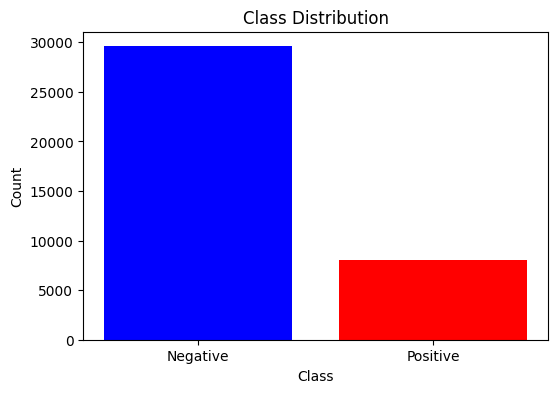

In [67]:
# Show the positive and negative class distribution
def plot_class_distribution(labels):
    # Count the number of positive and negative examples
    unique, counts = np.unique(labels, return_counts=True)
    counts_dict = dict(zip(unique, counts))

    # Convert dictionary keys and values to lists
    keys = list(counts_dict.keys())
    values = list(counts_dict.values())

    # Plot the class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(keys, values, color=['blue', 'red'])
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(labels_train)

In [ ]:
# Implement Butterworth filter
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def apply_filter(signals, lowcut, highcut, fs):
    filtered_signals = np.zeros(signals.shape)
    for i in range(signals.shape[0]):
        filtered_signals[i] = butter_bandpass_filter(signals[i], lowcut, highcut, fs)
    return filtered_signals

# Filter the signals from 1 to 40 Hz
train_filtered = apply_filter(inter_signals_train, 1, 40, sampling_rate)
#plot_eeg_signals(train_filtered)

# Plot the FFT of the filtered signals
plot_fft(train_filtered, 5, True, x_lim_max=130)

In [69]:
print('Train data shape is {}'.format(train_filtered.shape))
print('Labels shape for train is {}'.format(labels_train.shape))
print(f'Length of the first filtered signal is {len(train_filtered[1, 0])}')

Train data shape is (37666, 23, 256)
Labels shape for train is (37666,)
Length of the first filtered signal is 256


In [70]:
# Implement epoching to divide the data into X-ms epochs (we use 1000ms which is the same as the original data)
def epoch_signals(signals, start, end, sample_rate):
      # Calculate the number of samples per epoch
      samples_per_epoch = int((abs(start) + abs(end)) * (sample_rate / 1000))

      # Initialize an empty list to store the epochs
      epochs = []

      # Iterate over the signals
      for signal in signals:
            # Iterate over the channels
            for channel in signal:
                  # Iterate over the channel in steps of samples_per_epoch
                  for i in range(0, len(channel), samples_per_epoch):
                        # Extract the epoch
                        epoch = channel[i:i+samples_per_epoch]

                        # If the epoch is shorter than samples_per_epoch, discard it
                        if len(epoch) < samples_per_epoch:
                              continue

                        # Add the epoch to the list of epochs
                        epochs.append(epoch)

      # Convert the list of epochs to a numpy array and reshape it to match the original data shape
      epochs = np.array(epochs).reshape(len(signals), -1, samples_per_epoch)

      return epochs

start = 0
end = 1000

Several of the false cases have a skewed baseline. Below we will calculate the baseline for each channel for each case and reset the baseline to zero. This will allow the models to better compare the signals.

See https://www.youtube.com/watch?v=zDTsePeDlwo&t=745s for a discussion of the baseline.

In [71]:
# Create a function to apply baseline correction to the data (skip epoching)

def apply_baseline_correction(signals, baseline_start, baseline_end, sample_rate):
      # Calculate the number of samples per baseline
      samples_per_baseline = int((abs(baseline_start) + abs(baseline_end)) * (sample_rate / 1000))

      # Iterate over the signals
      for i in range(signals.shape[0]):
         # Iterate over the channels
         for j in range(signals.shape[1]):
               # Iterate over the channel in steps of samples_per_baseline
               for k in range(0, len(signals[i, j]), samples_per_baseline):
                  # Extract the baseline
                  baseline = signals[i, j, k:k+samples_per_baseline]

                  # If the baseline is shorter than samples_per_baseline, discard it
                  if len(baseline) < samples_per_baseline:
                     continue

                  # Subtract the mean of the baseline from the signal
                  signals[i, j, k:k+samples_per_baseline] -= np.mean(baseline)

      return signals

In [72]:
# No epoching is necessary
train_corrected = apply_baseline_correction(train_filtered, 0, 100, sampling_rate)

val_inter_signals = interpolate_zero_variance_channels(signals_val, verbose=False)
val_filtered = apply_filter(val_inter_signals, 1, 40, sampling_rate)
val_corrected = apply_baseline_correction(val_filtered, 0, 100, sampling_rate)

test_inter_signals = interpolate_zero_variance_channels(signals_test, verbose=False)
test_filtered = apply_filter(test_inter_signals, 1, 40, sampling_rate)
test_corrected = apply_baseline_correction(test_filtered, 0, 100, sampling_rate)

In [ ]:
print('Train data shape is {}'.format(train_corrected.shape))
plot_eeg_signals(train_corrected, examples=range(0, 2), channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [74]:
# Show the mean range of values for all channels averaged together over all examples
import plotly.graph_objects as go

def plot_mean_range(signals):
    # Create a figure
    fig = go.Figure()
    example_means_true = []
    example_means_false = []

    for i in range(signals.shape[0]):
        # Calculate the mean range of values for all channels
        mean_range = np.mean(np.ptp(signals[i], axis=1))
        if labels_train[i] == 1:
            example_means_true.append(mean_range)
        else:
            example_means_false.append(mean_range)

    trues_mean = np.mean(example_means_true)
    falses_mean = np.mean(example_means_false)

    # Plot the two means a bar chart
    fig.add_trace(go.Bar(x=['True', 'False'], y=[trues_mean, falses_mean], name='Mean Range of Values', marker_color= ['blue', 'red']))

    # Set the figure layout
    fig.update_layout(
        title='Mean Range of Values for All Channels<br> Averaged Together Over All Examples',
        title_x=0.5,
        xaxis_title='True and False Examples',
        yaxis_title='Mean Range of Values',
        barmode='group',
        width=400,
        height=400
    )

    # Show the figure
    fig.show()

plot_mean_range(train_corrected)

The above chart demonstrates that perhaps large value ranges (transients) are actual seizure-predictive features. However, they could also be blinking or other movement artifacts, and the real range of the signals is much smaller (closer to the range of the negative cases).

In [75]:
# Implement a function to remove channels with extreme values (e.g. > 1000 µV)
def remove_extreme_channels(signals, threshold):
    # Iterate over the signals
    for i in range(signals.shape[0]):
        # Iterate over the channels
        for j in range(signals.shape[1]):
            # If the channel has an extreme value, set it to zero
            if np.max(np.abs(signals[i, j])) > threshold:
                signals[i, j] = range(signals[i, j].shape[0])

    return signals

# Remove channels with extreme values
#train_cleaned = remove_extreme_channels(train_corrected, 300)

# Interpolate zero-variance channels
#train_cleaned = interpolate_zero_variance_channels(train_cleaned)

In [76]:
# Implement a function to sum the channels together
def average_channels(signals):
      # Sum the channels together
      summed_signals = np.sum(signals, axis=1)

      return summed_signals

# Average the channels together
#train_averaged = average_channels(train_corrected)
#val_averaged = average_channels(val_corrected)
#test_averaged = average_channels(test_corrected)


So far, epoching, summing channels, and interpolating extreme channels have not improved the accuracy of our model.

However, interpolating missing channels, filtering at 40Hz, and doing baseline correction between 0 and 100 samples have improved the accuracy of our model.

XDAWN was not applied to the averaged channels for obvious reasons, but it has been applied to all other techniques.

Below we are implementing XDAWN covariance matrix estimation. We will use the XDAWN algorithm to estimate the covariance matrix of the data to reduce dimensionality, training the classifier on the matrix as opposed to the raw data.

In [77]:
from pyriemann.estimation import XdawnCovariances

# Initialize the XdawnCovariances object
xdawn = XdawnCovariances(nfilter=5, applyfilters=False)  # nfilter is the number of spatial filters

xdawn.fit(train_corrected, labels_train)

train_xdawn = xdawn.transform(train_corrected)
val_xdawn = xdawn.transform(val_corrected)
test_xdawn = xdawn.transform(test_corrected)

# *_xdawn now contain the XDAWN covariance matrices for each epoch per dataset

In [78]:
# Rename the training and validation sets
X_train, X_test, y_train, y_test = train_xdawn, val_xdawn, labels_train, labels_val

# Reshape the XDAWN covariance matrices into a 2D array for the classifier
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
test_2D = test_xdawn.reshape(test_xdawn.shape[0], -1)
print('XDAWN train 2D shape:', X_train_2d.shape)

# Combine the training and validation sets
X_train_all = np.vstack((X_train_2d, X_test_2d))
y_train_all = np.hstack((y_train, y_test))

XDAWN train 2D shape: (37666, 1089)


In [90]:
from tensorflow.keras import layers, Model, optimizers, callbacks
import tensorflow as tf

input_ = layers.Input(shape=X_train_2d.shape[1])
# Define the layers
normalizer = layers.Normalization()
normalizer.adapt(X_train_2d)
normalization_layer = normalizer(input_)
hidden_layer1 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_1')(normalization_layer)
dropout1 = layers.Dropout(0.25)(hidden_layer1)
batch_norm_1 = layers.BatchNormalization()(dropout1)
hidden_layer2 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_2')(batch_norm_1)
dropout2 = layers.Dropout(0.25)(hidden_layer2)
batch_norm_2 = layers.BatchNormalization()(dropout2)
hidden_layer3 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_3')(batch_norm_2)
dropout3 = layers.Dropout(0.25)(hidden_layer3)
batch_norm_3 = layers.BatchNormalization()(dropout3)
hidden_layer4 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_4')(batch_norm_3)
dropout4 = layers.Dropout(0.25)(hidden_layer4)
batch_norm_4 = layers.BatchNormalization()(dropout4)
hidden_layer5 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_5')(batch_norm_4)
dropout5 = layers.Dropout(0.25)(hidden_layer5)
batch_norm_5 = layers.BatchNormalization()(dropout5)
hidden_layer6 = layers.Dense(128, activation="relu", kernel_initializer='he_normal', name='Dense_6')(batch_norm_5)
dropout6 = layers.Dropout(0.5)(hidden_layer6)
batch_norm_6 = layers.BatchNormalization()(dropout6)
hidden_layer7 = layers.Dense(128, activation="relu", kernel_initializer='he_normal', name='Dense_7')(batch_norm_6)
dropout7 = layers.Dropout(0.5)(hidden_layer7)
batch_norm_7 = layers.BatchNormalization()(dropout7)
hidden_layer8 = layers.Dense(128, activation="relu", kernel_initializer='he_normal', name='Dense_8')(batch_norm_7)
dropout8 = layers.Dropout(0.5)(hidden_layer8)
batch_norm_8 = layers.BatchNormalization()(dropout8)
hidden_layer9 = layers.Dense(128, activation="relu", kernel_initializer='he_normal', name='Dense_9')(batch_norm_8)
dropout9 = layers.Dropout(0.5)(hidden_layer9)

concat_layer = layers.Concatenate()
concat_layer = concat_layer([normalization_layer, dropout6,dropout7])
output_layer = layers.Dense(1, activation='sigmoid')(concat_layer)

# Define the model
model = Model(inputs=[input_], outputs=[output_layer])

# Define the model
deep_and_wide = Model(inputs=[input_], outputs=[output_layer], name='deep_and_wide')


# Compile the model
deep_and_wide.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'],
            sample_weight_mode=None,
        )

# Print the summary of the models
#print('Base model summary:')
#base.summary()

#print('CNN model summary:')
#cnn.summary()

#print('Deep sequential summary:')
#deep_sequential.summary()

print('Deep and Wide summary:')
deep_and_wide.summary()

# Implement early stopping, tensorboard callbacks, and a learning rate scheduler
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', # what to monitor
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None

)

lr_scheduler = callbacks.ReduceLROnPlateau(
   monitor='val_accuracy',
   factor=0.1,
   patience=3,
   verbose=1,
   min_lr=0.001)


Deep and Wide summary:
Model: "deep_and_wide"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 1089)]               0         []                            
                                                                                                  
 normalization_20 (Normaliz  (None, 1089)                 2179      ['input_21[0][0]']            
 ation)                                                                                           
                                                                                                  
 Dense_1 (Dense)             (None, 32)                   34880     ['normalization_20[0][0]']    
                                                                                                  
 dropout_180 (Dropout)       (None, 32)                   0    

In [91]:
# Assume we have 1000 samples and 10 time steps
num_samples = 37666

# Get the number of true and false samples
num_true_samples = np.sum(y_train)
num_false_samples = num_samples - num_true_samples

# We'll give a higher weight to the first half of the samples
sample_weight = np.zeros(num_samples)
for i in range(num_samples):
    if y_train[i] == 1:
        sample_weight[i] = 1
    else:
        sample_weight[i] = 0.5


# Train the deep_and_wide model
deep_and_wide_history = deep_and_wide.fit(X_train_2d, y_train,
                        validation_data=(X_test_2d, y_test),
                        epochs=100,
                        shuffle=True,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16,
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the deep_and_wide model
deep_and_wide_accuracy = deep_and_wide.evaluate(X_test_2d, y_test)[1]
print(f"Deep and wide model accuracy: {deep_and_wide_accuracy * 100}%")

Epoch 1/100
2354/2354 [==============================] - 20s 7ms/step - loss: 0.4108 - accuracy: 0.8459 - val_loss: 0.3770 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 2/100
2354/2354 [==============================] - 15s 6ms/step - loss: 0.3708 - accuracy: 0.8605 - val_loss: 0.3733 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 3/100
2354/2354 [==============================] - 15s 7ms/step - loss: 0.3519 - accuracy: 0.8652 - val_loss: 0.4335 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 4/100
2354/2354 [==============================] - 16s 7ms/step - loss: 0.3413 - accuracy: 0.8682 - val_loss: 0.3434 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 5/100
2354/2354 [==============================] - 15s 7ms/step - loss: 0.3259 - accuracy: 0.8714 - val_loss: 0.3392 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 6/100
2354/2354 [==============================] - 17s 7ms/step - loss: 0.3187 - accuracy: 0.8746 - val_loss: 0.3191 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/100
2354/2354 [=======================

In [92]:
# Plot the learning curves using plotly
def plot_learning_curves(history):
   # Create a figure
   fig = go.Figure()

    # Add the training and validation loss
   fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1), y=history.history['loss'], mode='lines', name='Training Loss'))
   fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], mode='lines', name='Validation Loss'))

    # Add the training and validation accuracy
   fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
   fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))

   # Update the layout
   fig.update_layout(
         title='Learning Curves',
         title_x=0.5,
         xaxis_title='Epoch',
         yaxis_title='Value',
         width=800,
         height=600
   )

   fig.show()

plot_learning_curves(deep_and_wide_history)


In [94]:
# Predict the test data
y_pred_deep_wide = deep_and_wide.predict(test_2D)
y_pred_deep_wide = (y_pred_deep_wide > 0.5).astype(int)

df = pd.DataFrame(y_pred_deep_wide, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
df.to_csv(f'{filename}.csv', header=True)

253/253 [==============================] - 1s 5ms/step
Enter the name for the predictions:deep_and_wide_non_seq_v1


## Report (new deep and wide non-sequential model)

The deep and wide model was troublesome to work with, much more unstable than the sequential models. I experimented with several different combinations of paths in the concatenate layer, and found that the deeper layers were far more consistent in their convergence. It also seemed like the shallow layers (the first few) did better with fewer neurons than the deeper layers, which means that the more complex features were being learned in the deeper layers. However, the features being learned in the shallower layers (those with 32 filters) did not make sense to the final classification, such as when I included 'dropout2' or 'dropout3' (those being the last operations on fully connected layers 2 and 3). The nature of the data seems to require a relatively deep model, but not so wide. I left additional layers in the model though they are not being used, for reference. I found that after hidden_layer6, adding any more layers with the same number of more filters caused the model to overfit the data.

The kaggle score is 89.47%, so not terrible, it just needs more TLC.

